In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train[:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
test[:10]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [5]:
ntrain = train.shape
ntest = test.shape

In [6]:
print("data size is {}, and test size is {}".format(ntrain,ntest))

data size is (891, 12), and test size is (418, 11)


In [7]:
num = np.array(train.dtypes!="object")
print("numeric type",sum(num) )
cat = np.array(train.dtypes=="object")
print("object type", sum(cat))

numeric type 7
object type 5


In [8]:
numerical = [f for f in train.columns if train.dtypes[f] != 'object']
numerical.remove('Survived')
# we don't required (Id not a feature)
numerical.remove('PassengerId')
print(numerical)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [9]:
categorical = [f for f in train.columns if train.dtypes[f] == 'object']
print(categorical)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


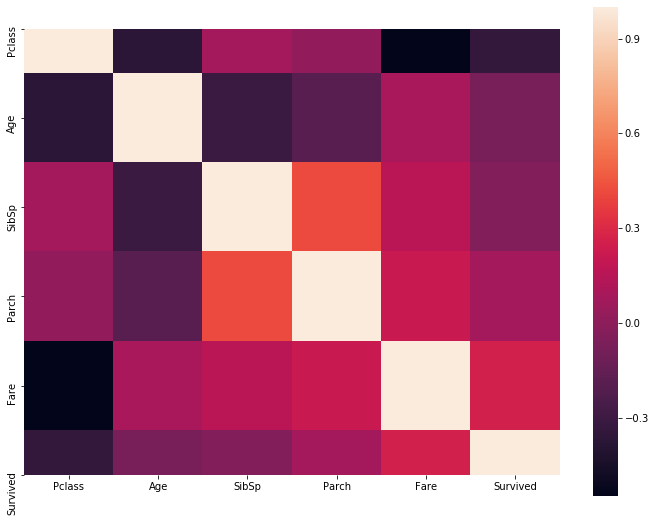

In [10]:
num = numerical + ['Survived']
corrmat = train[num].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

In [22]:
train1 = train.drop(["PassengerId","Survived","Name","Ticket","Fare","Cabin"],axis = 1)
test1 = test.drop(["PassengerId","Name","Ticket","Fare","Cabin"],axis = 1)

In [23]:
train1.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,22.0,1,0,S
1,1,female,38.0,1,0,C
2,3,female,26.0,0,0,S
3,1,female,35.0,1,0,S
4,3,male,35.0,0,0,S


In [24]:
test1.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,34.5,0,0,Q
1,3,female,47.0,1,0,S
2,2,male,62.0,0,0,Q
3,3,male,27.0,0,0,S
4,3,female,22.0,1,1,S


In [25]:
y = train["Survived"]
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [26]:
all_data = pd.concat((train1, test1)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1309, 6)


In [27]:
all_data.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,22.0,1,0,S
1,1,female,38.0,1,0,C
2,3,female,26.0,0,0,S
3,1,female,35.0,1,0,S
4,3,male,35.0,0,0,S


In [28]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
Age,20.091673
Embarked,0.152788


In [31]:
all_data["Embarked"] = all_data["Embarked"].fillna('None')

In [32]:
all_data["Age"] = all_data["Age"].fillna(all_data["Age"].mean())

In [33]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


In [34]:
all_data.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,22.0,1,0,S
1,1,female,38.0,1,0,C
2,3,female,26.0,0,0,S
3,1,female,35.0,1,0,S
4,3,male,35.0,0,0,S


In [35]:
from sklearn.preprocessing import LabelEncoder
col = ('Embarked','Sex')
# process columns, apply LabelEncoder to categorical features
for c in col:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (1309, 6)


In [36]:
all_data.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,1,22.0,1,0,3
1,1,0,38.0,1,0,0
2,3,0,26.0,0,0,3
3,1,0,35.0,1,0,3
4,3,1,35.0,0,0,3


In [41]:
train2 = all_data[:ntrain[0]]
test2 = all_data[ntrain[0]:]

In [42]:
train2.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,1,22.0,1,0,3
1,1,0,38.0,1,0,0
2,3,0,26.0,0,0,3
3,1,0,35.0,1,0,3
4,3,1,35.0,0,0,3


In [43]:
test2.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked
891,3,1,34.5,0,0,2
892,3,0,47.0,1,0,3
893,2,1,62.0,0,0,2
894,3,1,27.0,0,0,3
895,3,0,22.0,1,1,3


In [ ]:
X = train2

In [44]:
X_train,X_test,y_train,y_test = train_test_split(train2,y,test_size = 0.3,random_state= 0)

In [45]:
X_train.head(3)

,Pclass,Sex,Age,SibSp,Parch,Embarked
857,1,1,51.0,0,0,3
52,1,0,49.0,1,0,0
386,3,1,1.0,5,2,3


In [48]:
y_train.head(3)

857    1
52     1
386    0
Name: Survived, dtype: int64

In [62]:
models = [
    ('LR', LogisticRegression()),
    ('NB', GaussianNB()),
    ('SVM', SVC()),
    ('KNN', KNeighborsClassifier()),
    ('DT', DecisionTreeClassifier()),
]

In [84]:
pred = dict()
for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    pred[name] = y_pred

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [85]:
for name, model in models:
    score = accuracy_score(y_test, pred[name])
    print("{} accuracy score is : {}".format(name,score))

LR accuracy score is : 0.7910447761194029
NB accuracy score is : 0.7798507462686567
SVM accuracy score is : 0.7835820895522388
KNN accuracy score is : 0.753731343283582
DT accuracy score is : 0.7649253731343284


In [93]:
for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(test2)
    y_data = {'Survived': y_pred}
    new_data = pd.DataFrame(data = y_data, index = test["PassengerId"])
    new_data.to_csv("result_3tr_{}.csv".format(name))

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [86]:
all_pred = dict()
for name, model in models:
    clf = model
    clf.fit(train2,y)
    y_pred = clf.predict(train2)
    all_pred[name] = y_pred

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [87]:
for name, model in models:
    score = accuracy_score(y, all_pred[name])
    print("{} accuracy score is : {}".format(name,score))

LR accuracy score is : 0.7946127946127947
NB accuracy score is : 0.7878787878787878
SVM accuracy score is : 0.8653198653198653
KNN accuracy score is : 0.8383838383838383
DT accuracy score is : 0.9371492704826038


In [94]:
for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(test2)
    y_data = {'Survived': y_pred}
    new_data = pd.DataFrame(data = y_data, index = test["PassengerId"])
    new_data.to_csv("result_3all_{}.csv".format(name))

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
